# So like yeah this is an iPython notebook for the project

It's split into three parts:
- discretizing audio
- general mcmc for sampling from multivariate normal
- sample from audio
- see what happens

## Part 1: discretizing speech with short time fourier transform

Basically, speech is constant, but we can discretize it making it easy to analyze, while still having enough data to reconstruct it into audio. The goal is to discretize it, map it from our speech distribution to someone else's (both of which will require Metropolis-Hastings), and play it back in the other person's voice.

In [1]:
import IPython
IPython.display.Audio('marvin.wav')

In [2]:
IPython.display.Audio('marvin2.wav')

In [16]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib import cm
import numpy as np
n = 12
spec_kwargs = {'NFFT': n, 'Fc':0, 'noverlap': n/2, 'window':mlab.window_hanning, 'cmap':cm.gray_r}

Some data on the spoken word "marvin" for speaker 1: 
16000 samples, sampled at 16000 Hz


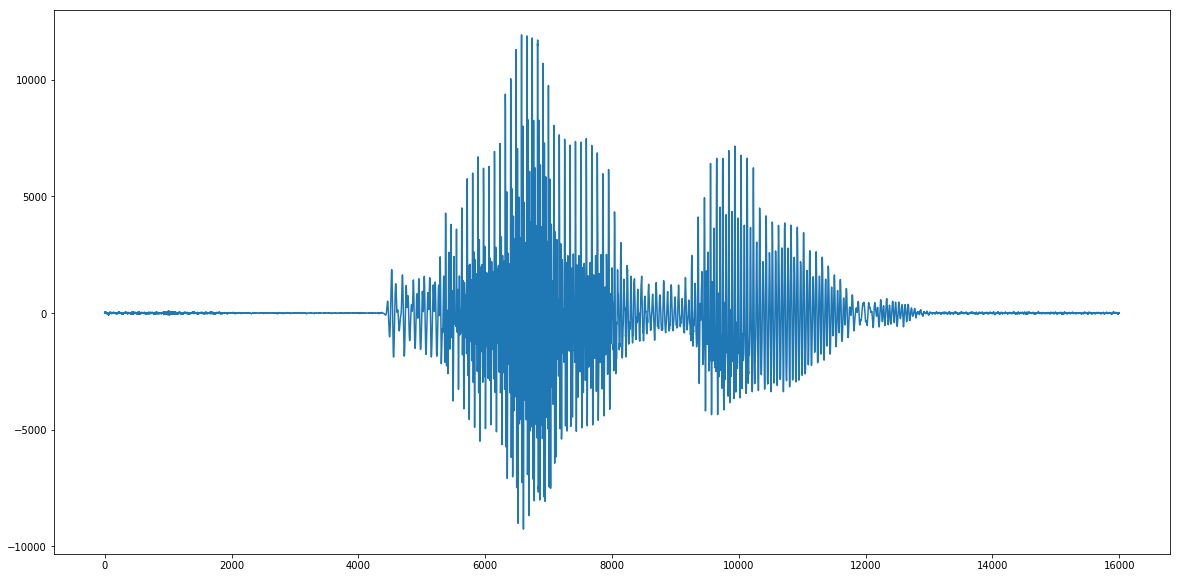

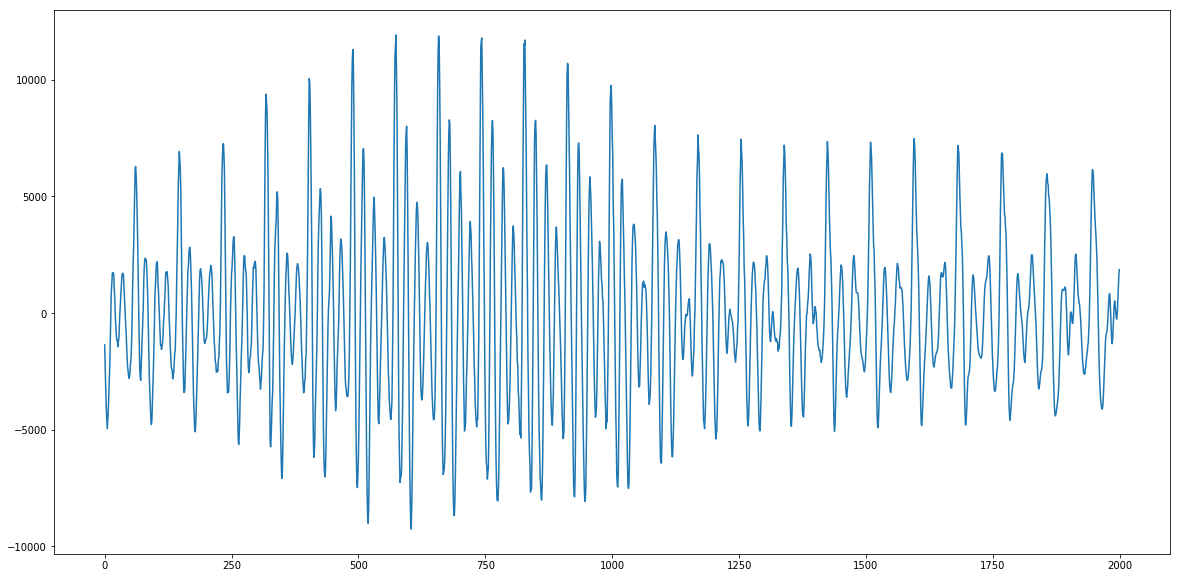

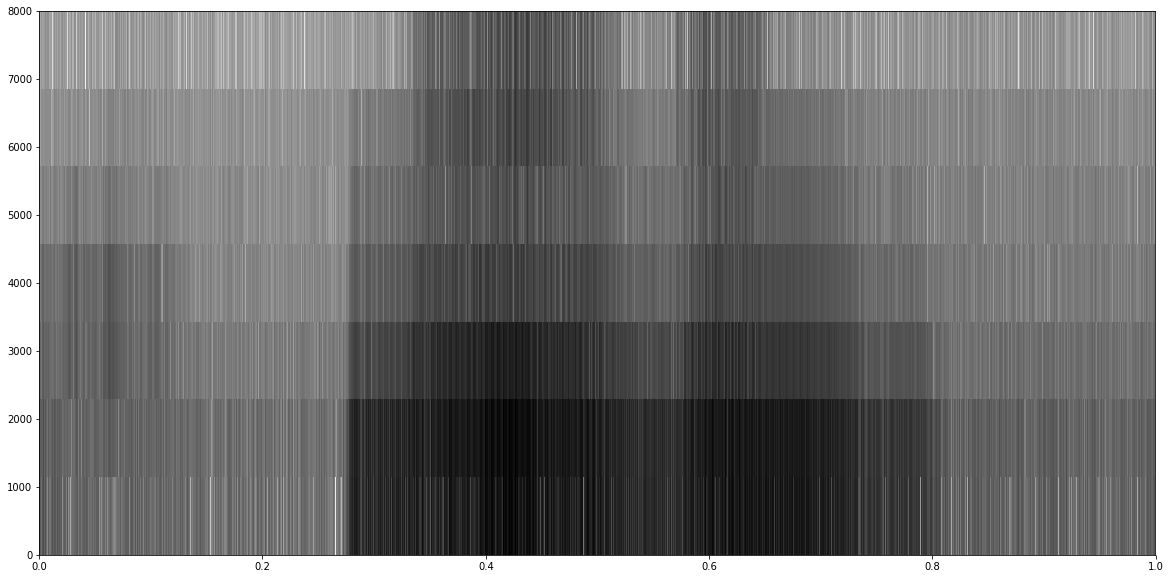

In [17]:
rate1, marvin1 = read('marvin.wav')
print('Some data on the spoken word "marvin" for speaker 1: ')
print(f'{marvin1.shape[0]} samples, sampled at {rate1} Hz')
plt.figure(figsize=(20,10))
plt.plot(marvin1)
plt.figure(figsize=(20,10))
plt.plot(marvin1[6000:8000])
plt.figure(figsize=(20,10))
s, _, _, _ = plt.specgram(marvin1, Fs=rate1, **spec_kwargs)

Alright, time to use my Ling 110 skills! Looking at the spectrogram, we can see general trends. The bar at the bottom is called the "voicing bar" and marks any voiced sound (think 'v' vs 'b'). All the sounds in the word "marvin" are usually voiced, so this is constant. We also see some lines moving up and down, like from 0.3 to 0.5 we see one line rising from 1500 Hz to 2000 Hz and one falling from 3000 Hz to 2000 Hz. These are the F1 and F2 formant frequencies, the important parts of a vowel sound.

for speaker 2: 
16000 samples, sampled at 16000 Hz


/Users/aayush/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


[2.94635128e-02 2.18107096e-02 8.15431596e-04 5.65517622e-05
 6.28635977e-05 5.54142433e-05 1.59255763e-05]


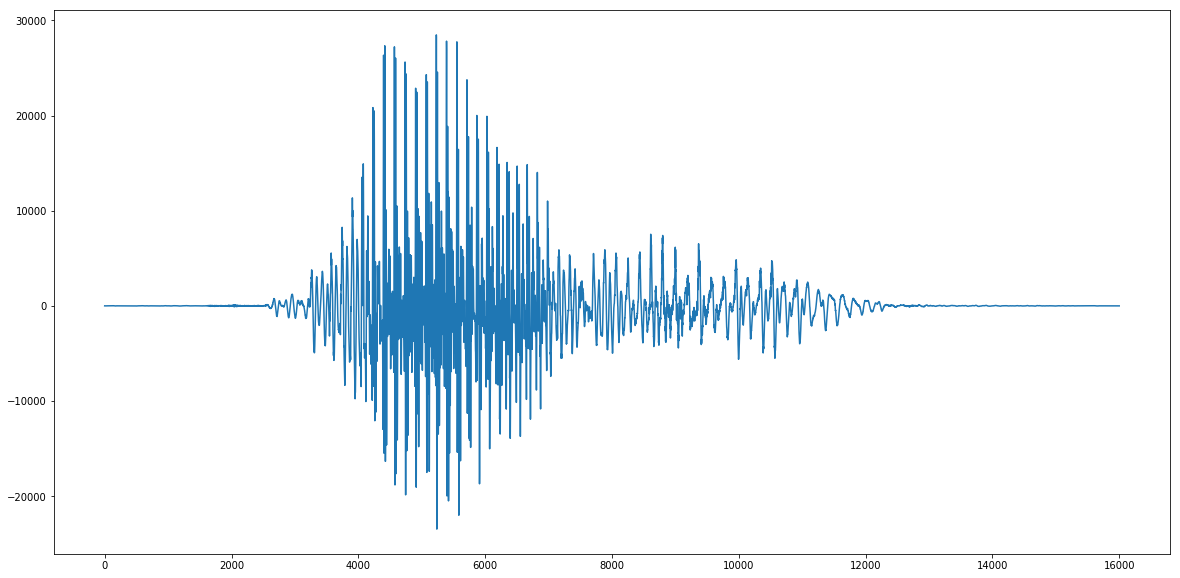

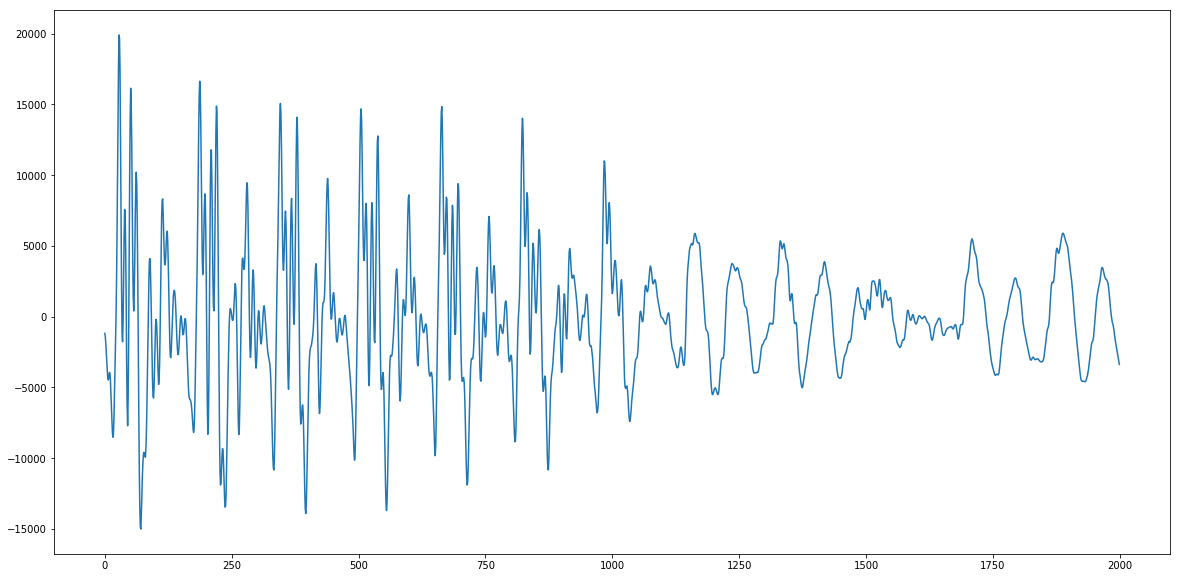

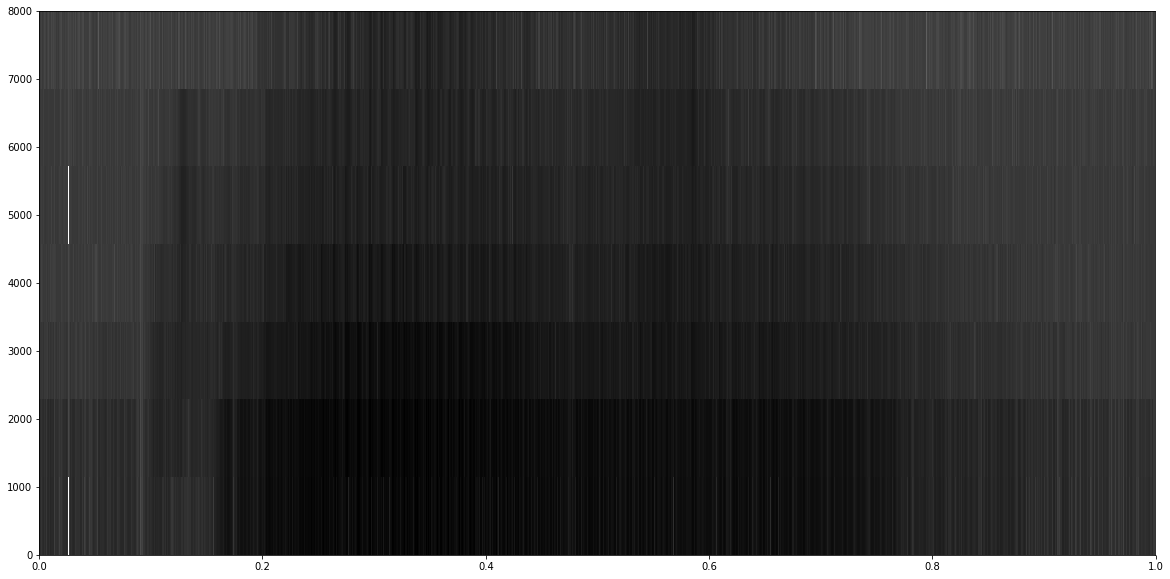

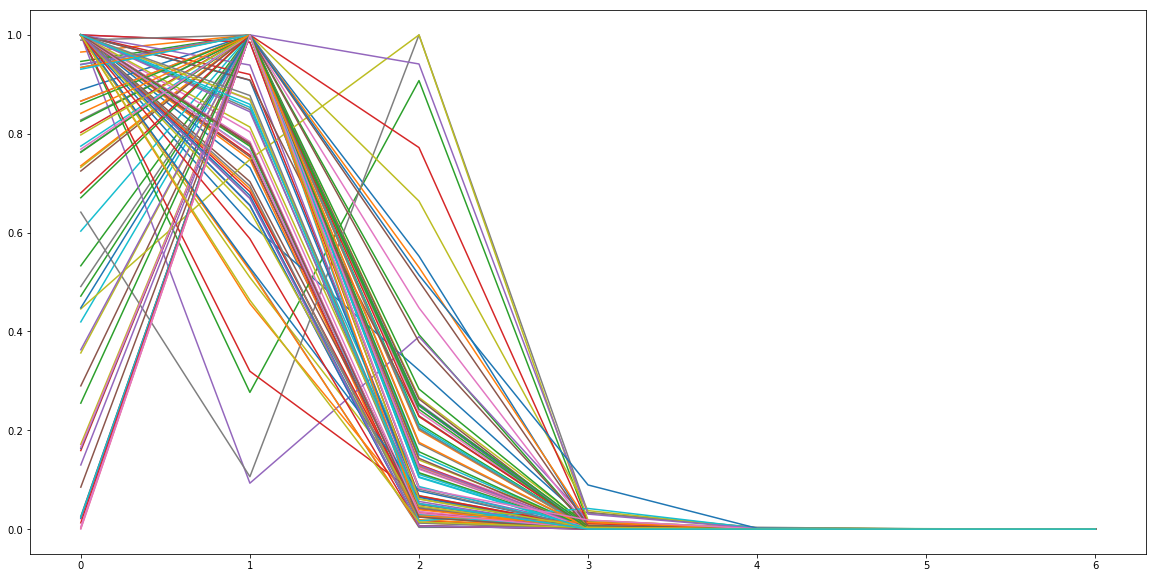

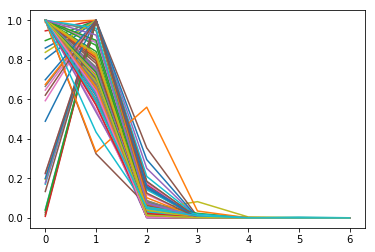

<Figure size 432x288 with 0 Axes>

In [25]:
rate2, marvin2 = read('marvin2.wav')
print('for speaker 2: ')
print(f'{marvin2.shape[0]} samples, sampled at {rate2} Hz')
plt.figure(figsize=(20,10))
plt.plot(marvin2)
plt.figure(figsize=(20,10))

plt.plot(marvin2[6000:8000])
plt.figure(figsize=(20,10))
spectrum, _, _, _ = plt.specgram(marvin2, Fs=rate2, **spec_kwargs)
plt.figure(figsize=(20,10))
# for i in range(int(spectrum.shape[1] * 0.4), int(spectrum.shape[1] * 0.4 + 100)): 
#     plt.plot(spectrum[:, i] / np.amax(spectrum[:, i]))
#     plt.plot(s[:, i+int(spectrum.shape[1] * 0.1)] / np.amax(s[:, i+int(spectrum.shape[1] * 0.1)]))
#     plt.figure()
# for i in range(int(spectrum.shape[1] * 0.4), int(spectrum.shape[1] * 0.4 + 100)): 
#     plt.plot(spectrum[:, i] / np.amax(spectrum[:, i]))
# plt.figure()
# for i in range(int(spectrum.shape[1] * 0.5), int(spectrum.shape[1] * 0.5 + 100)): 
#     plt.plot(s[:, i] / np.amax(s[:, i]))
# plt.figure()
print(spectrum[:, 160])

Aaaand if you're not convinced that we can reproduce speech from this discretized, choppy looking data, here's the audio reconstructed from the same spectrogram for marvin1.

In [23]:
from scipy import signal
fft_kwargs = {'fs': rate1, 'nperseg': n/2}
_, _, spectrum1 = signal.stft(marvin1, **fft_kwargs)
print(spectrum1.shape)
_, marvin_reconstructed = signal.istft(spectrum1, **fft_kwargs)
print(marvin_reconstructed)
IPython.display.Audio(data=marvin_reconstructed, rate=rate1)

(4, 5335)
[ 2.5833333+0.j 35.166668 +0.j 37.166668 +0.j ... 11.416667 +0.j
 13.916667 +0.j  0.       +0.j]
[ 5.1666665+0.j 70.333336 +0.j 74.333336 +0.j ... 22.833334 +0.j
 27.833334 +0.j  0.       +0.j]


In [ ]:
print('The data is formatted like this')
freqs, t, spectrum2 = signal.stft(marvin2, **fft_kwargs)
spectrum2

## Part 2: Getting the distribution from speech

Now our goal is to use multivariate Metropolis-Hastings to sample a distribution of sounds from two different speakers.

In [ ]:
# copied from LAB 4
def metropolis_hastings(proposal_func, init_func, acceptance_score, num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    proposal_func -- function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    acceptance_score -- function that calculates the acceptance
        probability; takes in two state samples
        (candidate first, then the current sample) and returns
        acceptance probability
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    samples = []
    sample = init_func()
    for i in range(num_iters):
        candidate = proposal_func(sample)
        acceptance_ratio = min(1, acceptance_score(candidate,sample))
        if np.random.uniform() < acceptance_ratio:
            sample = candidate
            samples.append(sample)
    return samples[::step]

In [ ]:
IPython.display.Audio('target.wav')

Some data on the targets speech: 
11088736 samples, sampled at 16000 Hz


/Users/aayush/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


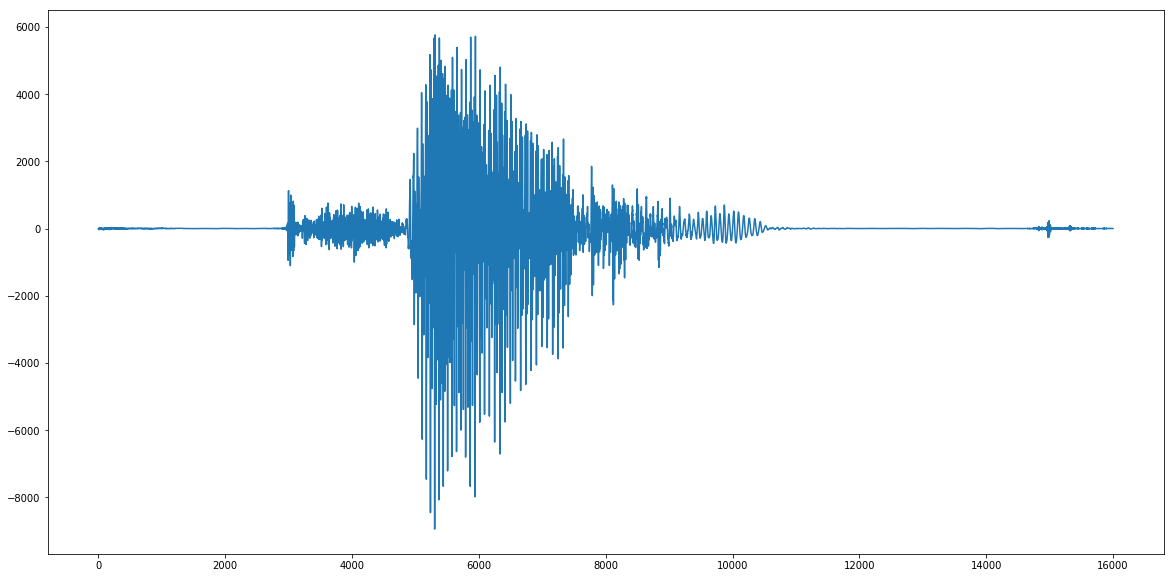

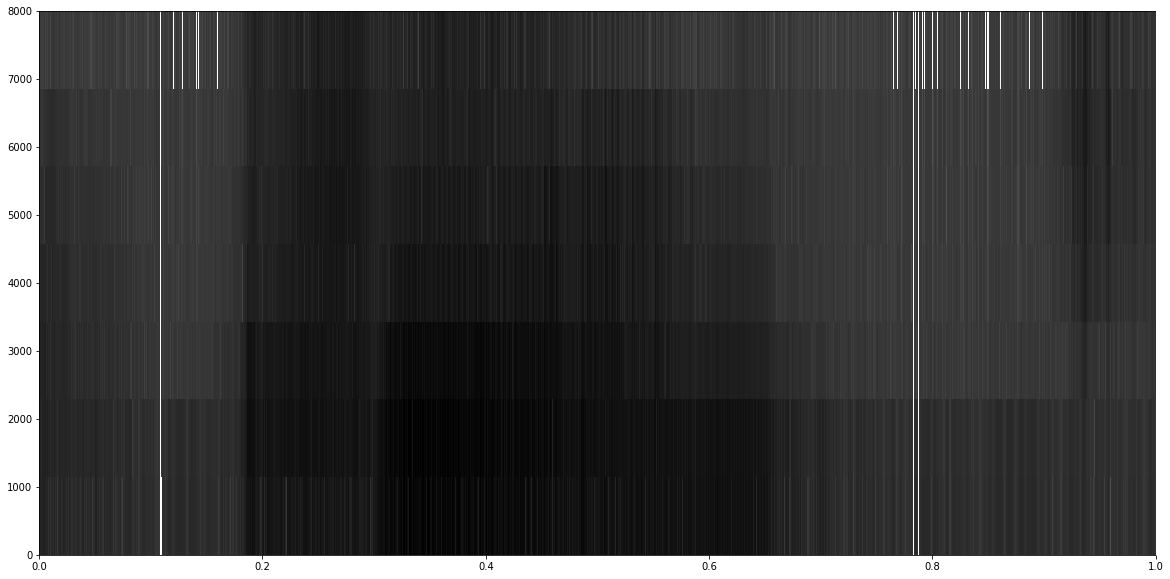

In [75]:
rate, target = read('target.wav')
print('Some data on the targets speech: ')
print(f'{target.shape[0]} samples, sampled at {rate} Hz')
plt.figure(figsize=(20,10))
plt.plot(target[40000:56000])
plt.figure(figsize=(20,10))
_ = plt.specgram(target[40000:56000], Fs=rate, **spec_kwargs)

In [71]:
import math
def scientific(x):
    x = x**2
    if x == 0:
        return ('0', '0')
    power = math.floor(math.log(x, 10))
    return str(int(round(x / (10 ** power)))), str(power)

def bucket(sample):
    scaled = sample / np.amax(sample)
    return ' '.join([str(int(c * 20)) for c in scaled])


/Users/aayush/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/Users/aayush/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


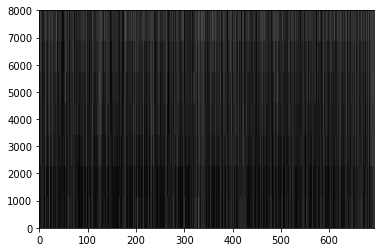

In [76]:
dtarget = distribution(target)

In [78]:
for k in dtarget:
    if dtarget[k] > 15:
        print(dtarget[k])

112212
111759
397
19
103
171987
39244
15866
267
13829
1570
68097
28
9000
9186
32
19
62
64
16560
247
60
118
6832
32
58
599
801
272
712
41
3595
1524
2007
101
67
1807
1421
2771
469
1035
31
39
368
5337
21
446
64
74
20
16
54
17
7951
259
2502
1911
16
16
28
1614
18318
903
823
40540
67
7498
20
4341
595
453
78
302
70
69
20
2585
24
16
453
64
19
16
30
39
262
59
41
1446
545
178
17
418
16
18
1083
17
30
394
947
772
21
210
234
21032
201
4035
686
123
2001
3922
29
25
19
591
26
19
37
79
20109
33
100
71
90
26
2019
4248
28
19
23
28
138
104
63
66
19
209
110
606
846
28
25
1640
346
197
22
5790
24
8419
5642
24
108
4902
12529
7153
817
29
1491
3026
2462
129
1252
2620
2653
1439
2524
1879
25
124
160
98
4914
100
37
188
1547
2120
4479
3474
2059
2098
5686
2438
6807
3008
3793
4522
2479
3676
6706
2961
2992
6752
2004
3301
1982
2518
2502
3454
2153
4296
1789
3182
5760
2890
1563
191
2871
2098
2000
684
736
2650
440
493
1483
2222
206
3251
1328
2164
1102
118
34
127
17
17
9407
47
23
187
116
23
37
1907
107
16
664
470
347
136
7

40
22
26
25
33
18
23
19
91
24
45
27
34
42
144
49
27
30
38
19
69
47
63
26
20
29
152
17
17
24
39
51
19
16
38
52
18
19
29
23
67
40
79
55
29
50
37
26
18
58
21
18
33
29
120
145
54
40
59
19
20
19
159
28
53
30
16
19
116
34
177
18
29
22
84
55
99
33
59
41
23
27
75
36
18
106
121
64
17
21
23
30
53
40
27
26
42
20
19
19
53
18
92
81
34
16
42
167
40
32
17
26
38
16
22
58
16
17
35
19
31
20
26
18
45
23
19
34
29
54
20
28
59
70
17
22
39
48
17
81
18
44
43
30
29
27
47
24
48
43
53
19
25
54
20
16
16
24
88
28
46
29
74
38
17
32
18
35
44
24
24
103
22
28
16
57
53
19
49
21
44
64
21
153
29
49
32
66
25
33
23
16
20
64
32
35
27
23
33
62
137
20
27
24
47
36
44
42
34
69
77
34
39
37
50
34
28
37
21
42
48
22
40
97
20
28
26
39
30
20
16
77
16
70
20
110
35
123
44
109
101
24
16
41
31
16
31
50
20
36
46
18
67
68
70
17
47
16
27
38
72
24
21
16
19
50
63
67
31
27
16
139
17
17
35
44
16
23
18
54
160
118
24
19
42
70
18
55
18
31
52
325
36
38
22
21
18
19
18
20
17
59
48
26
31
17
38
16
31
27
87
33
134
39
33
16
20
25
20
16
17
45
17
31
21
24


/Users/aayush/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/Users/aayush/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1911 1083
6832 68097
664 111759
821 68097
39244 20109
69 344
303 337
9 111759
3093 112212
3093 111759
31 21032
1 903
152 112212
20109 171987
1 4
3 103
70 10
54 171987
4 2771
224 111759
91 68097
78 32
10 68097
3 111759
50 171987
545 171987
308 12
15866 9
40540 111759
37 39244
109 111759
9 9000
435 1887
396 14
111759 2502
7498 203
12 111759
165 368
916 2
5337 68097
112212 171987
87 71
4341 1911
87 2
134 32
293 55
2 2
818 2
117 71
77 111759
1 112212
2 171987
6 15866
44 111759
11 111759
1591 112212
9 5760
18 1
18 59
7 112212
36 111759
25 68097
8 171987
7 39244
2 171987
1 112212
2 112212
46 171987
1 171987
5 171987
36 8419
3 903
12 39244
1 72
46 1907
5 7951
29 9186
276 112212
221 112212
122 101
4341 15866
6 111759
2 111759
2 97
10 2
3 40540
57 111759
10 68097
5 15866
1 111759
4 68097
77 111759
2 158
2 2
97 8419
290 9407
1 68097
1 18318
46 15866
3 68097
73 171987
6 111759
5 112212
38 87
39 83
76 2
58 6807
13 171987
79 111759
1 15866
501 13829
5 39244
6 68097
13 121
60 111759
1 171987
13 4341

6807 111759
112212 171987
2992 112212
21032 5642
68097 817
2518 241
40540 3301
21032 4914
6807 772
111759 4
3182 20109
5790 171987
12529 68097
112212 171987
2222 191
111759 18318
18318 171987
2992 112212
111759 39244
711 112212
20109 68097
171987 112212
6706 4296
40540 111759
68097 112212
2000 171987
1924 112212
68097 112212
40540 171987
2479 9407
171987 9186
2518 171987
68097 112212
111759 112212
2545 111759
111759 111759
9186 541
5790 40540
112212 112212
3793 171987
12529 112212
845 5642
18318 21032
2890 171987
16560 171987
21032 112212
3210 112212
111759 112212
4479 171987
16560 111759
171987 2438
2620 21032
40540 112212
171987 112212
2120 112212
112212 171987
4296 112212
928 171987
197 16560
20109 9407
1392 171987
16560 171987
111759 112212
5642 171987
12529 112212
171987 3793
3454 40540
40540 171987
68097 171987
111759 112212
397 20109
1957 300
11 111759
6807 112212
111759 112212
7153 171987
9407 112212
39244 171987
40540 20109
2464 3210
111759 18318
68097 15866
1809 111759
111759

31 39244
264 20109
9 1353
2871 823
15866 111759
474 821
171987 1344
152 6832
111759 112212
7498 111759
166 112212
8 111759
68 1570
300 40540
12529 672
29 68097
5760 112212
111759 171987
6 112212
410 112212
143 68097
20109 9186
68097 12529
21032 68097
2 112212
2407 112212
112212 112212
1491 111759
2004 39244
76 112212
4248 39244
860 2007
111759 111759
10 111759
7 5760
111759 4248
5686 13829
111759 171987
15866 6832
18318 112212
9 111759
622 111759
188 5337
6 39244
111759 112212
22 171987
3251 171987
112212 171987
3251 40540
68097 4902
1252 171987
545 171987
2890 171987
68097 171987
1341 39244
42 171987
3 171987
5 171987
78 39244
1 6832
18318 13829
6 5
8419 30
40540 94
20109 8419
3676 68097
15866 39244
18318 112212
2771 112212
250 112212
368 112212
2120 39244
1314 111759
18 4296
21032 39244
112212 68097
40540 112212
11 111759
272 112212
171987 15866
40540 39244
8 112212
4914 171987
8 39244
20109 190
1837 4296
112212 40540
1924 68097
12 112212
20 433
272 1353
137 40540
17 387
68097 29
392

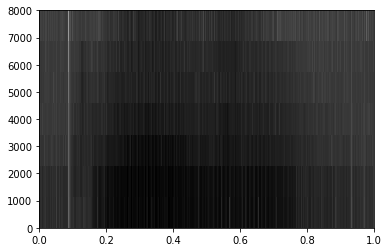

In [79]:
from sklearn.preprocessing import normalize
def distribution(audio_signal):
    freqs, t, spectrum = signal.stft(audio_signal, **fft_kwargs)
    _, new_audio = signal.istft(spectrum, **fft_kwargs)
    bucket_spectrum, _, _, _ = plt.specgram(new_audio, Fs=16000, **spec_kwargs)
    distribution = {}
    for i in range(bucket_spectrum.shape[1]):
        try:
            sample = bucket_spectrum[:, i]
            b = bucket(sample)
            if b in distribution:
                distribution[b] += 1
            else:
                distribution[b] = 1
        except:
            pass
    return distribution

d1 = distribution(marvin1)
d2 = distribution(marvin2)


pratio = 1 # the probability of marvin1 over probability of marvin2 in distribution target
spec1, _, _, _ = plt.specgram(marvin1, Fs=16000, **spec_kwargs)
spec2, _, _, _ = plt.specgram(marvin2, Fs=16000, **spec_kwargs)
for i in range(spec1.shape[1]):
    try:
        b1 = bucket(spec1[:, i])
        b2 = bucket(spec2[:, i])
        if dtarget.get(b2) and dtarget.get(b1):
            print(dtarget[b1], dtarget[b2])
            pratio += math.log(dtarget[b1]) - math.log(dtarget[b2])
    except:
        pass
print(pratio)
    

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
freqs, t, spectrum = signal.stft(target, **fft_kwargs)
# def transform(sample):
#     return np.vectorize(lambda c: complex(c.real * c.real, c.imag))(sample)
# transformed_spectrum = np.apply_along_axis(transform, 0, spectrum)
# _, new_audio = signal.istft(transformed_spectrum, **fft_kwargs)
# Dropping most of the spectrogram - still recognizable but garbled
# c = 0.9
# for i in range(spectrum.shape[1]):
#     sample = spectrum[:, i]
#     cutoff = c * np.amax(sample)
#     sample[abs(sample.real) < cutoff] = 0
print(bucket(spectrum[:, 456]))
print(bucket(spectrum[:, 457]))
print(bucket(spectrum[:, 458]))
print(bucket(spectrum[:, 459]))
print(bucket(spectrum[:, 460]))
print(bucket(spectrum[:, 461]))
print(bucket(spectrum[:, 462]))
print(bucket(spectrum[:, 463]))
# # try inserting rows to transform voice
# new_spectrum = np.insert(spectrum[:-1, :], 1, np.zeros(spectrum.shape[1]), 0)

# # try deleting a row see what happens
# new_spectrum = np.vstack((np.delete(spectrum, 0, axis=0), np.zeros(spectrum.shape[1])))

_, new_audio = signal.istft(spectrum, **fft_kwargs)
plt.figure(figsize=(20,10))
_ = plt.specgram(new_audio[40000:56000], Fs=rate, **spec_kwargs)
IPython.display.Audio(data=new_audio, rate=rate)